In [341]:
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
import pandas as pd
import numpy as np
import random
# Ensembl methods: Adaboost & Gradient Boosting & RF
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cross_validation import train_test_split 

#Artificial Neural Network packages
import keras 
from keras.models import Sequential
from keras.layers import Dense


Using TensorFlow backend.


# Read in high quality imputed data

In [ ]:
Negatives = pd.read_csv('IMPUTED_NEGs.csv', sep="\t") #index_col=False
Positive_cat_dat = pd.read_csv('IMP_pos_datcat.csv', sep="\t") #index_col=False
Positive_num = pd.read_csv('IMPUTED_pos_num.csv', sep="\t") #index_col=False

# Preprocessing the Crème de la crème

In [11]:
# A little preprocessing.
new_df = pd.merge(Positive_cat_dat, Positive_num, on=Positive_num.Id)
new_df = new_df.drop(['Id_y', 'Response_y'], axis=1)
Positives = new_df.rename(columns={'Id_x': 'Id', 'Response_x': 'Response'})
#set(Negatives.columns) - set(new_df.columns)
Negatives = Negatives.drop(['Id.1', 'Response.1'], axis=1)

In [18]:
rows = random.sample(Negatives.index, 20000)
Negative_s = Negatives.ix[rows]
Negative_HODL = Negatives.drop(rows)

# Create dataframe of 1815 high quality positives and 20,000 samples of high quality negatives 

In [16]:
# combine positive and negatives
frames = [Negative_s, Positives]
data = pd.concat(frames)


# Read in data from original sparse data set - to preturb data quality and guard the generalization ability of models.

In [ ]:
bad_negatives = pd.read_csv('All_50000samps_negatives_all_quality.csv', sep="\t") #index_col=False

### Remove duplicates between high quality and low quality negative dataset

In [21]:
bad_negatives = bad_negatives.drop('Unnamed: 0', 1)

In [42]:
common = bad_negatives['Id'].isin(Negative_s['Id']) 

In [47]:
bad_neg = bad_negatives[common==False] #.shape # if true, remove from bad_negatives.

In [ ]:
# Find categorical columns with multiple outputs

In [53]:
Cat_Head = pd.read_csv('CAT_HEADS.csv', sep=",") #index_col=False

In [75]:
Cat_Head.head(n=1)

,Id,L0_S1_F25,L0_S1_F27,L0_S1_F29,L0_S1_F31,L0_S2_F33,L0_S2_F35,L0_S2_F37,L0_S2_F39,L0_S2_F41,...,L3_S49_F4225,L3_S49_F4227,L3_S49_F4229,L3_S49_F4230,L3_S49_F4232,L3_S49_F4234,L3_S49_F4235,L3_S49_F4237,L3_S49_F4239,L3_S49_F4240


In [80]:
bad_cat_head = bad_neg[Cat_Head.columns]

In [81]:
#Here we show that all other columns other than Id has only binary categories...
# This means there is no point in trying to fill in Nas because only one class exist. 
duplicateCount = bad_cat_head.T.apply(lambda x: x.nunique(), axis=1) # Here we show that 
multiple_cat_heads = duplicateCount[duplicateCount > 2]

In [84]:
multiple_cat_heads = multiple_cat_heads.drop("Id")

In [85]:
multiple_bad_cat_heads = bad_neg[multiple_cat_heads]

In [88]:
bad_neg_picked = bad_neg[Positives.columns] # chosen by positive feature selection

In [96]:
Neg_result = pd.concat([bad_neg_picked, multiple_bad_cat_heads], axis=1)

# Sample from low quality negative samples with informative categorical columns

In [98]:
rows = random.sample(Neg_result.index, 10000)
Negative_cat = Neg_result.ix[rows]

In [99]:
Negative_cat.head(n=1)

,Id,L3_S29_F3317,L3_S29_F3320,L3_S29_F3323,L3_S29_F3326,L3_S29_F3329,L3_S29_F3332,L3_S29_F3335,L3_S29_F3338,L3_S29_F3341,...,L0_S2_F37,L0_S2_F61,L0_S1_F31,L0_S1_F31,L0_S1_F31,L0_S1_F31,L0_S1_F29,L0_S1_F29,L0_S1_F29,L0_S1_F29
3644,51272,T1,T1,T1,T1,T1,T1,T1,T1,T1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
Negative_cat.shape

(10000, 438)

In [ ]:
# Perturb high quality negative samples with low quality samples.

In [101]:
Negative_s.shape

(20000, 346)

In [122]:
common_negative_cols = list(set(Negative_s.columns).intersection(set(Negative_cat.columns)))

In [123]:
result = pd.merge(Negative_cat, Negative_s, how='outer', on=common_negative_cols)

# Repeat for Positive samples - add in loq quality data + categorical columns containing multiple entries

In [128]:
Positives.shape

(1815, 346)

# Read in low quality Positive classes

In [129]:
bad_positives = pd.read_csv('All_positives_all_quality.csv', sep="\t") #index_col=False

In [131]:
common = bad_positives['Id'].isin(Positives['Id']) 

In [133]:
bad_pos = bad_positives[common==False] # Remove duplicate rows

In [167]:
bad_positives = bad_pos[Positives.columns] ## .shape

In [172]:
Perturbed_Positives = pd.concat([bad_positives, Positives])

In [179]:
columns_to_drop = set(Perturbed_Negatives.columns) - set(Perturbed_Positives.columns)

In [182]:
Perturbed_Neg = Perturbed_Negatives.drop(columns_to_drop, axis=1)  

In [186]:
Perturbed_Neg.to_csv("Perturbed_Negatives.csv", sep='\t', index= False )

In [187]:
Perturbed_Positives.to_csv("Perturbed_Positives.csv", sep='\t', index= False )

# Split data in train-test set and HODL

In [192]:
Perturbed = pd.concat([Perturbed_Neg, Perturbed_Positives])

In [222]:
#Perturbed.select_dtypes(include=['object'])

In [227]:
Perturbed = Perturbed.replace(['T1'], [1])

In [238]:
Perturbed = Perturbed.fillna(0)

In [239]:
Perturbed_X = Perturbed.drop(['Response'], axis=1)

In [240]:
Perturbed_Y = Perturbed[['Response']]

In [241]:
X_trainTest, X_HODL, y_trainTest, y_HODL = train_test_split(Perturbed_X, Perturbed_Y , test_size= 0.2, random_state = 888)

In [242]:
ALL_trainTest = X_trainTest.join(y_trainTest)

In [243]:
ALL_HODL = X_HODL.join(y_HODL)

In [233]:
ALL_trainTest.shape

(28729, 346)

In [234]:
ALL_HODL.shape

(6594, 346)

# Under-sampling

In [286]:
def DownSample_Negatives(AllData, Num_samps):
    neg_indices = AllData[AllData.Response == 0].index # all indexes of negative samples
    samp_neg_indices = np.random.choice(neg_indices, Num_samps, replace=False) # sample from neg indices
    down_samp_negs = AllData.loc[samp_neg_indices] # retrieve from data
    return(down_samp_negs)
def DownSample_Positives(AllData, Num_samps):
    pos_indices = AllData[AllData.Response == 1].index # all indexes of negative samples
    samp_pos_indices = np.random.choice(pos_indices, Num_samps, replace=False) # sample from neg indices
    down_samp_pos = AllData.loc[samp_pos_indices] # retrieve from data
    return(down_samp_pos)
def DownSample(AllData, Num_samps):
    neg_indices = AllData.index # all indexes of negative samples
    samp_neg_indices = np.random.choice(neg_indices, Num_samps, replace=False) # sample from neg indices
    down_samp_negs = AllData.loc[samp_neg_indices] # retrieve from data
    return(down_samp_negs)

In [297]:
ALL_TT = ALL_trainTest.reset_index()

In [304]:
trainTest_neg_downSamp = DownSample_Negatives(ALL_TT,3500)
#Trainy[Trainy.Response == 1].shape
#Testy = DownSample(data,2000)
#Testy[Testy.Response == 1].shape

In [307]:
trainTest_neg_downSamp.shape

(3500, 347)

In [305]:
trainTest_pos = ALL_TT[ALL_TT.Response == 1]

In [306]:
trainTest_pos.shape

(3413, 347)

In [308]:
ALL_TT = pd.concat([trainTest_neg_downSamp, trainTest_pos])

# Model fitting

# Optimize Chosen Models

## - Random Forrest
## - Gradient Boosting
## - Neural Network

In [244]:
def DoRForest(X_trainIn, y_trainIn, X_testIn, DepthIn, MaxFeatIn):
    #model = RandomForestClassifier(criterion=CriterionIn, n_estimators = DepthIn, max_features= MaxFeatIn)
    model = RandomForestClassifier(criterion="entropy", n_estimators = DepthIn, max_features= MaxFeatIn)
    model.fit(X_trainIn, y_trainIn)
    RF_y_predictions = model.predict(X_testIn)
    return(RF_y_predictions)

In [274]:
# Function to create a confusion matrix
def DoConfMat(yTestIn, yPredIn):
    Confusion_M1 = confusion_matrix(yTestIn, yPredIn) #.ravel()
    tn = Confusion_M1[0][0]
    fp = Confusion_M1[0][1]
    fn = Confusion_M1[1][0]
    tp = Confusion_M1[1][1]
    
    MCC= (float((tp*tn))-(fp*fn)) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ALL1 = tn + fp + fn + tp 
    stat_accuracy1 = float(tp + tn)/ALL1
    stat_misclassification_rate1 = float(fp + fn) / ALL1
    stat_false_negative1 = float(fn) / (tp + fn) # false negative rate
    stat_false_positive1 = float(fp) / (fp + tn) # false positive rate
    stat_sensitivity1 = float(tp) / (tp + fn) # false negative rate
    stat_specificity1 = float(tn) / (tn + fp)
    stat_precision1  = float(tp)/(tp+fp)
    
    return(stat_accuracy1, stat_misclassification_rate1, stat_sensitivity1, stat_false_positive1, stat_specificity1, stat_false_negative1, stat_precision1, MCC)
    
    

In [279]:
# def TrainClassifier(costIn, gammaIn, randomSplit):

def cross_validate_roc(mydataIn, num_k_param, param1, param2):
    mydataIn = mydataIn.sample(frac=1) # randomly shuffle data, frac parameter define what fraction of data to return - frac= 1  means we return all data shuffled
    folds = np.array_split(mydataIn, num_k_param)
    num_k = int(len(folds)) 
    CV_accuracy = []
    
    # K fold cross validation
    for i in range(0,num_k):
        Ktest = folds[i]
        Ktrain = []
        for j in xrange(len(folds)):
            if j != i:
                Ktrain.append(folds[j])  
        Ktrain = pd.concat(Ktrain)
        
        KX_train = Ktrain.drop('Response', 1)         
        KX_test = Ktest.drop('Response',1)              
        Ky_train = Ktrain['Response'] 
        Ky_test = Ktest['Response'] 
    
        #outty = DoGB(X_trainIn=KX_train, y_trainIn=Ky_train, X_testIn=KX_test)
        #outty = DoSVM(X_trainIn=KX_train, y_trainIn=Ky_train, X_testIn=KX_test, costIn=costIn, gammaIn=gammaIn)
        outty= DoRForest(X_trainIn=KX_train, y_trainIn=Ky_train, X_testIn=KX_test, DepthIn=param1, MaxFeatIn=param2)
        
        Ky_predictions = outty
        
        # ACCURACY
        #Kclassification_stats = accuracy_score(y_true=Ky_test, y_pred=Ky_predictions)
        #CV_accuracy.append(Kclassification_stats)
        
        # MCC
        # 
        Kclassification_stats = DoConfMat(yTestIn=Ky_test, yPredIn=Ky_predictions)
        CV_accuracy.append(Kclassification_stats[7])

    stat_accuracy2 = sum(CV_accuracy)/len(CV_accuracy)
    return stat_accuracy2


# Optimize a Random Forrest with Grid Search

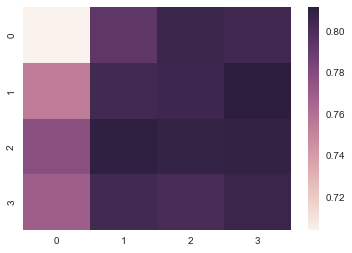

In [320]:
MaxFeat = [10, 30, 60, 90]
MaxDepth = [10, 30, 60, 90]

def GridSearch(P_List1, P_List2):
    acc_row = []
    for i in (P_List1):
        acc_columns = []
        for j in (P_List2):
            acc =cross_validate_roc(mydataIn=ALL_TT, num_k_param=3, param1=i, param2=j)
            acc_columns.append(acc)
        acc_row.append(acc_columns)
        
    heat = sns.heatmap(acc_row)
    return acc_row

GridOut = GridSearch(P_List1=MaxFeat, P_List2=MaxDepth)


In [322]:
cross_validate_roc(mydataIn=ALL_TT, num_k_param=3, param1=30, param2=90)

0.80541725363113958

# Best Random Forest Parameters
### DepthIn=30
### MaxFeatIn=90

In [495]:
all_TT.shape


(6913, 345)

In [494]:
all_HODL.shape

(6594, 345)

In [498]:
all_T_Target = all_TT[['Response']]


array([ 0.,  0.,  0., ...,  1.,  1.,  1.])

In [499]:
all_T_Feats = all_TT.drop(['Response'], axis=1)

In [501]:
all_HODL_Target = all_HODL[['Response']]


In [502]:
all_HODL_Feats = all_HODL.drop(['Response'], axis=1)

In [508]:
RF_out = DoRForest(X_trainIn=all_T_Feats, y_trainIn=all_T_Target.values.ravel(), X_testIn=all_HODL_Feats, DepthIn=30, MaxFeatIn=90)


In [509]:
DoConfMat(yTestIn=all_HODL_Target.values.ravel(), yPredIn=BSUS)


(0.7388535031847133,
 0.2611464968152866,
 0.9810606060606061,
 0.28222881635344543,
 0.7177711836465546,
 0.01893939393939394,
 0.23228699551569507,
 0.40090919262370722)

# Optimize Gradient Boosting with Random Search

In [325]:
def DoGB(X_trainIn, y_trainIn, X_testIn, a,b,c,d):
    model = GradientBoostingClassifier(min_samples_split= a, max_depth=b, min_weight_fraction_leaf=c, max_features=d)
    model.fit(X_trainIn, y_trainIn)
    D_y_predictions = model.predict(X_testIn)
    return(D_y_predictions)

In [327]:
def cross_validate_roc(mydataIn, num_k_param, a,b,c,d):
    mydataIn = mydataIn.sample(frac=1) # randomly shuffle data, frac parameter define what fraction of data to return - frac= 1  means we return all data shuffled
    folds = np.array_split(mydataIn, num_k_param)
    num_k = int(len(folds)) 
    CV_accuracy = []
    
    # K fold cross validation
    for i in range(0,num_k):
        Ktest = folds[i]
        Ktrain = []
        for j in xrange(len(folds)):
            if j != i:
                Ktrain.append(folds[j])  
        Ktrain = pd.concat(Ktrain)
        
        KX_train = Ktrain.drop('Response', 1)         
        KX_test = Ktest.drop('Response',1)              
        Ky_train = Ktrain['Response'] 
        Ky_test = Ktest['Response'] 
    
        outty = DoGB(X_trainIn=KX_train, y_trainIn=Ky_train, X_testIn=KX_test,a=a, b=b, c=c, d=d)
        Ky_predictions = outty

        # MCC
        # 
        Kclassification_stats = DoConfMat(yTestIn=Ky_test, yPredIn=Ky_predictions)
        CV_accuracy.append(Kclassification_stats[7])

    stat_accuracy2 = sum(CV_accuracy)/len(CV_accuracy)
    return stat_accuracy2

In [ ]:
# min_samples_split (a) = 1- 4000 # number of samples to use per split
# max depth of a tree (b) = 5-100
# min_weight_fraction_leaf (c) = 0.1-0.5
# max feat (d) =  should be 30% - 40% of 347


In [332]:
def RandomSearch():
    acc_collect = []
    params = []
    for i in range(0,10):
        a1 = int(round(np.random.uniform(low=40, high=2000, size=1)))
        b1 = int(round(np.random.uniform(low=5, high=100, size=1)))
        c1 = float(np.random.uniform(low=0.1, high=0.5, size=1))
        d1 = int(round(np.random.uniform(low=100, high=200, size=1)))
        acc = cross_validate_roc(mydataIn=ALL_TT, num_k_param=3, a=a1,b=b1,c=c1,d=d1)
        params.append([a1,b1,c1,d1])
        acc_collect.append(acc)
    sorted_acc, params_out = zip(*sorted(zip(acc_collect, params)))
    #print sorted_acc
    fin_a = params_out[-1][0]
    fin_b = params_out[-1][1]
    fin_c = params_out[-1][2]
    fin_d = params_out[-1][3]
    return [fin_a, fin_b, fin_c, fin_d, sorted_acc[-1]]

In [333]:
RandomSearch()

[964, 90, 0.2750062705238385, 132, 0.87881727104103902]

In [334]:
RandomSearch()

[948, 34, 0.16580295996847916, 120, 0.87967123153224647]

# Best Grandient Boost params:
### min_samples_split (a) = 948
### max depth of a tree (b) = 34
### min_weight_fraction_leaf (c) = 0.165
### max feat = 0.878

# Artificial neural network

In [445]:
def ANN(X_train, y_train, X_test):
    X_shape = X_train.shape  # IMPORTANT FOR INPUT LAYER PARAMETER!!!!
    num_features = X_shape[1]
    #initialize ANN by defining it as a sequence of layers
    model = Sequential()
    #Adding input layer
    #activation function parameter set to 'relu' = rectifier function 
    #uniform = intialization method
    model.add(Dense(output_dim = 6, init = 'uniform', activation = 'relu', input_dim = num_features))
    # Add 3 hidden layer
    model.add(Dense(output_dim = 6, init = 'uniform', activation = 'relu'))
    model.add(Dense(output_dim = 6, init = 'uniform', activation = 'tanh'))
    model.add(Dense(output_dim = 6, init = 'uniform', activation = 'linear'))

    # Add output layer
    model.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))
    # Apply stochastic gradient descent
    model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])
    # Choose number of epochs 

    model.fit(X_train.values, y_train.values, batch_size=30, nb_epoch = 15)
    y_predictions = model.predict(X_test.values)
    y_predictions = (y_predictions > 0.5)  #if y_pred is larger than 0.5, it returns CANCER TRUE, if not, returns false
    return y_predictions

In [425]:
ALL_T_Target = ALL_TT[['Response']]

In [426]:
ALL_T_Feats = ALL_TT.drop(['Response'], axis=1)

In [427]:
ALL_T_Feats = ALL_T_Feats.drop(['index'], axis=1)

In [428]:
ALL_T_Feats = ALL_T_Feats.drop(['Id'], axis=1)

In [429]:
HODL_Target = ALL_HODL[['Response']]

In [430]:
HODL_Feats = ALL_HODL.drop(['Response'], axis=1)

In [ ]:
HODL_Feats = HODL_Feats.drop(['index'], axis=1)

In [432]:
HODL_Feats = HODL_Feats.drop(['Id'], axis=1)

In [446]:
ANN_preds = ANN(X_train=ALL_T_Feats, y_train=ALL_T_Target, X_test=HODL_Feats)


Epoch 1/15
6913/6913 [==============================] - 1s - loss: 0.6209 - acc: 0.6835     
Epoch 2/15
6913/6913 [==============================] - 1s - loss: 0.5449 - acc: 0.7064     
Epoch 3/15
6913/6913 [==============================] - 1s - loss: 0.5215 - acc: 0.7278     
Epoch 4/15
6913/6913 [==============================] - 1s - loss: 0.5109 - acc: 0.7282     
Epoch 5/15
6913/6913 [==============================] - 0s - loss: 0.5062 - acc: 0.7282     
Epoch 6/15
6913/6913 [==============================] - 0s - loss: 0.5040 - acc: 0.7282     
Epoch 7/15
6913/6913 [==============================] - 1s - loss: 0.5026 - acc: 0.7282     
Epoch 8/15
6913/6913 [==============================] - 1s - loss: 0.5018 - acc: 0.7282     
Epoch 9/15
6913/6913 [==============================] - 0s - loss: 0.5012 - acc: 0.7282     
Epoch 10/15
6913/6913 [==============================] - 1s - loss: 0.5008 - acc: 0.7282     
Epoch 11/15
6913/6913 [==============================] - 0s - loss: 0

In [447]:
DoConfMat(yTestIn=HODL_Target, yPredIn=ANN_preds)


(0.5122838944494995,
 0.48771610555050043,
 1.0,
 0.5301681503461919,
 0.4698318496538081,
 0.0,
 0.14102564102564102,
 0.25740694973463885)

# Bagging bootstrap under sampling to deal with class imbalance 

In [475]:
def DoGB_default(X_trainIn, y_trainIn, X_testIn):
    model = GradientBoostingClassifier()
    model.fit(X_trainIn, y_trainIn)
    D_y_predictions = model.predict(X_testIn)
    return(D_y_predictions)

In [482]:
def Bootstrap_underSamp(trainIn, testIn, num_boots, cutOff):
    pred_collect = []
    testX = testIn.iloc[:,:-1]
    #print testX.shape
    for i in range(0,num_boots):
        
        # down sample positive samples by 0.725 to 0.875
        # thos np.random numbers determine the amount of under sampling from positive and negative classes. 
        #num_samp_pos = int(float(round(trainIn[trainIn.Response == 1].shape[0])) * np.random.uniform(0.725,0.875)) 
        #num_samp_neg = int(float(round(trainIn[trainIn.Response == 0].shape[0])) * np.random.uniform(0.05,0.125))
        num_samp_pos = int(float(round(trainIn[trainIn.Response == 1].shape[0])) * np.random.uniform(0.725,0.875)) 
        num_samp_neg = int(float(round(trainIn[trainIn.Response == 0].shape[0])) * np.random.uniform(0.725,0.875))
        downNeg = DownSample_Negatives(trainIn, num_samp_neg)
        downPos = DownSample_Positives(trainIn, num_samp_pos)
        recomb = pd.concat([downNeg,downPos])
        #print recomb.shape

        trainX = recomb.iloc[:,:-1]
        trainY = recomb.iloc[:,-1]

        pred = DoGB_default(X_trainIn=trainX, y_trainIn=trainY, X_testIn=testX)
        #pred= DoGB(X_trainIn=trainX, y_trainIn=trainY, X_testIn=testX,a=948, b=34, c=0.165, d=0.878)

        pred_collect.append(pred)
    pred_fractions = map(np.mean, zip(*pred_collect))
    pred = [1 if x >= cutOff else 0 for x in pred_fractions]
    return(pred)
    

In [457]:
all_HODL = ALL_HODL.drop(['Id'], axis=1)

In [468]:
all_TT = ALL_TT.drop(['Id', 'index'], axis=1)

In [483]:
BSUS= Bootstrap_underSamp(trainIn=all_TT, testIn=all_HODL, num_boots=10, cutOff=0.5)


In [484]:
DoConfMat(yTestIn=HODL_Target, yPredIn=BSUS)


(0.7388535031847133,
 0.2611464968152866,
 0.9810606060606061,
 0.28222881635344543,
 0.7177711836465546,
 0.01893939393939394,
 0.23228699551569507,
 0.40090919262370722)

# Stacking

In [488]:
mod1 = RandomForestClassifier(criterion="gini")
mod2 = AdaBoostClassifier()
mod3 = GradientBoostingClassifier()

In [489]:
stack = [mod1, mod2, mod3]

In [491]:
def Stacker(trainIn, testIn, stackIn, cutOff):
    pred_collect = []
    # preprocess
    testX = testIn.iloc[:,:-1]
    trainX = trainIn.iloc[:,:-1]
    trainY = trainIn.iloc[:,-1]
    
    for ind in range(0,len(stackIn)):
        clf =stackIn[ind]
        moddy = clf.fit(trainX, trainY)
        pred_y = moddy.predict(testX)
        pred_collect.append(pred_y)
        
    pred_fractions = map(np.mean, zip(*pred_collect))
    pred = [1 if x >= cutOff else 0 for x in pred_fractions]
    return pred
        

In [492]:
predStack = Stacker(trainIn=all_TT, testIn=all_HODL, stackIn=stack, cutOff=0.5)

In [493]:
DoConfMat(yTestIn=HODL_Target, yPredIn=predStack)

(0.7699423718531999,
 0.2300576281468001,
 0.9583333333333334,
 0.2464556544675239,
 0.7535443455324761,
 0.041666666666666664,
 0.25287356321839083,
 0.42024424326199672)

# Boot strap under sample stacker 

In [523]:
def Bootstrap_underSamp_Stacker(trainIn, testIn, num_boots, cutOff):
    pred_collect = []
    #testX = testIn.iloc[:,:-1]
    #print testX.shape
    for i in range(0,num_boots):
        
        # down sample positive samples by 0.725 to 0.875
        # thos np.random numbers determine the amount of under sampling from positive and negative classes. 
        #num_samp_pos = int(float(round(trainIn[trainIn.Response == 1].shape[0])) * np.random.uniform(0.725,0.875)) 
        #num_samp_neg = int(float(round(trainIn[trainIn.Response == 0].shape[0])) * np.random.uniform(0.05,0.125))
        #print trainIn.shape
        num_samp_pos = int(float(round(trainIn[trainIn.Response == 1].shape[0])) * np.random.uniform(0.725,0.875)) 
        num_samp_neg = int(float(round(trainIn[trainIn.Response == 0].shape[0])) * np.random.uniform(0.725,0.875))
        downNeg = DownSample_Negatives(trainIn, num_samp_neg)
        downPos = DownSample_Positives(trainIn, num_samp_pos)
        recomb = pd.concat([downNeg,downPos])
        #print recomb.shape
        
        #recomb = recomb.iloc[:,:-1]
        #print type(testX)
        #print type(recomb)
        #print recomb.shape
        pred = Stacker(trainIn=recomb, testIn=testIn, stackIn=stack, cutOff=0.5)

        #trainX = recomb.iloc[:,:-1]
        #trainY = recomb.iloc[:,-1]

        #pred = DoGB_default(X_trainIn=trainX, y_trainIn=trainY, X_testIn=testX)
        #pred= DoGB(X_trainIn=trainX, y_trainIn=trainY, X_testIn=testX,a=948, b=34, c=0.165, d=0.878)

        pred_collect.append(pred)
    pred_fractions = map(np.mean, zip(*pred_collect))
    pred = [1 if x >= cutOff else 0 for x in pred_fractions]
    return(pred)

In [524]:
BSUS2= Bootstrap_underSamp_Stacker(trainIn=all_TT, testIn=all_HODL, num_boots=10, cutOff=0.5)


In [525]:
DoConfMat(yTestIn=HODL_Target, yPredIn=BSUS2)

(0.7622080679405521,
 0.23779193205944799,
 0.9678030303030303,
 0.25568743818001977,
 0.7443125618199802,
 0.032196969696969696,
 0.2478176527643065,
 0.41689758384241588)

# Had I more time:

### - Applied K-means clustering to find underlying structure in data - and see if data can be split by certain categories 
### - Optimized my models with other techniques other than Grid Search / Random search
### - Investigated effects of perturbing the data with different levels of poor quality data
### - Ran the genetic algorithm for enough iterations to achieve stronger performance
### - Put more time into accurate imputation via regression + optimized regression models. 
### - Imputed categorical columns with classification
### - Look further into what the data is ... explore time series components if it exist + investigate of autocorrelation
### - Look at dealing with class imbalance with cost assymetry + more advanced sampling techniqies (eg. SMOTE)
### - More visualisations eg. ROC Curves.
### - Explore effect of PCA further


# Stuff I threw away - eg. Particle Swarm Optimization - They following code does not work - I did not finish because I did not want to take advantage of your patience - but I'll keep it as proof of effort...

In [ ]:
import math

#   If the fitness value is better than the best fitness value (pBest) in history
#            set current value as the new pBest

class Particle:
    def __init__(self, name):
        self.name = name
        
        # pick a random number between 0 and 1
        # if 
        
        paramms = RandomSearch()
        self.costy =  paramms[0] #float(np.random.uniform(low=-1, high=5, size=1)) 
        self.gammax = paramms[1] #float(np.random.uniform(low=-4, high=-1, size=1)) 
        self.x_pos = np.exp(self.gammax)
        self.y_pos = np.exp(self.costy)
        self.fitness_Value = paramms[2]
        self.velocity_X = 0
        self.velocity_Y = 0 

        # each particle keeps a track of it's own local best.
        self.particle_tracker = []
        self.pbest = paramms[2]

        self.max_X_boundary = 10.0 ** 6 
        self.min_X_boundary = 10.0 ** -6 
        self.max_Y_boundary = 10.0 ** 6
        self.min_Y_boundary = 10.0 ** -6
        
        
    def change_position(self, new_x, new_y):
        self.x_pos = new_x
        self.y_pos = new_y
        #global x_pos
        #global y_pos
        #x_pos = int(np.random.uniform(low=1, high=100, size=1)) 
        #y_pos = int(np.random.uniform(low=1, high=100, size=1))
    def change_velocity(self, heatX, heatY):


        #v[] = v[] + c1 * rand() * (pbest[] - present[]) + c2 * rand() * (gbest[] - present[]) (a)
        #present[] = persent[] + v[] (b)

        #v[] is the particle velocity 
        #persent[] is the current particle (solution). 
        #pbest[] and gbest[] are defined as stated before. 
        #rand () is a random number between (0,1). 
        #c1, c2 are learning factors. usually c1 = c2 = 2. 
        r1 = float(np.random.uniform(low=0.0, high=1.0, size=1))
        r2 = float(np.random.uniform(low=0.0, high=1.0, size=1))  
        c1 = 2.0
        c2 = 2.0
        pbest_vs_pres_X = self.pbest[1] - self.x_pos # local best X - particle X
        pbest_vs_pres_Y = self.pbest[2] - self.y_pos # local best Y - paticle Y
        gbest_vs_pres_X = heatX - self.x_pos # global best X - particle X
        gbest_vs_pres_Y = heatY - self.y_pos # gloabl best Y - particle Y

        pbest_update_X = c1 * r1 * float(pbest_vs_pres_X)
        gbest_update_X = c2 * r2 * float(gbest_vs_pres_X)
        pbest_update_Y = c1 * r1 * float(pbest_vs_pres_Y)
        gbest_update_Y = c2 * r2 * float(gbest_vs_pres_Y)

        X_vel_change = float(self.velocity_X) + float(pbest_update_X) + float(gbest_update_X)
        Y_vel_change = float(self.velocity_Y) + float(pbest_update_Y) + float(gbest_update_Y)

        potential_new_x_pos = self.x_pos + float(X_vel_change)
        potential_new_y_pos = self.y_pos + float(Y_vel_change)

        ### sometimes this does not work - got to get that rule right! 
        #self.x_pos = potential_new_x_pos
        #self.y_pos = potential_new_y_pos

        if potential_new_x_pos > self.min_X_boundary and potential_new_x_pos <= self.max_X_boundary:
            self.x_pos = potential_new_x_pos
        else:
            if potential_new_x_pos <= self.min_X_boundary:
                potential_new_x_pos = self.x_pos + X_vel_change
                dif_to_min = abs(potential_new_x_pos)
                self.x_pos = dif_to_min
            if potential_new_x_pos > self.max_X_boundary:
                potential_new_x_pos = self.max_X_boundary - (self.x_pos + X_vel_change) 
                dif_to_min = abs(potential_new_x_pos) 
                self.x_pos = dif_to_min


        if potential_new_y_pos > self.min_Y_boundary and potential_new_y_pos <= self.max_Y_boundary:
            self.y_pos = potential_new_y_pos
        else:
            if potential_new_y_pos <= self.min_Y_boundary:
                potential_new_y_pos = self.y_pos + Y_vel_change
                dif_to_min = abs(potential_new_y_pos)
                self.y_pos = dif_to_min
            if potential_new_y_pos > self.max_Y_boundary:
                potential_new_y_pos = self.max_Y_boundary - (self.y_pos + Y_vel_change) 
                dif_to_min = abs(potential_new_y_pos) 
                self.y_pos = dif_to_min


    def track_results(self, EvalScoreIn, CurrentX, CurrentY):
        self.particle_tracker.append((EvalScoreIn, CurrentX, CurrentY))

    def update_pbest(self):
        current_tracker = self.particle_tracker
        current_tracker = list(reversed(sorted(current_tracker)))
        current_local_best = current_tracker.pop()  # finds minimum eval score
        self.pbest = current_local_best

        

In [ ]:


P1 = Particle("Particle 1")
P2 = Particle("Particle 2")
P3 = Particle("Particle 3")
P4 = Particle("Particle 4") 
P5 = Particle("Particle 5")
P6 = Particle("Particle 6")
P7 = Particle("Particle 7")
P8 = Particle("Particle 8")


In [ ]:
# downsampling
from /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages import imblearn
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages')
import sys, os.path
imblearn_dir = (os.path.abspath(os.path.join(os.path.dirname(__file__), '..')) + 
                '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages')
sys.path.append(imblearn_dir)

In [ ]:
import sys
sys.path.insert(0,'/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages')

In [ ]:
import imblearn

In [ ]:
# Fit model with bagging

In [ ]:
# Fit a model with stacking